# 第十七次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW17-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">5月25日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

## 请认真阅读代码，理解代码的功能
### 创建变量
pytorch创建变量的语法与numpy有许多相似之处。下面列举了pytorch创建变量的一些常见用法：

In [2]:
import torch
import numpy as np

# 创建一个张量（tensor）
x = torch.tensor([1, 2, 3, 4])
print("x:", x)

# 创建一个矩阵（matrix）
y = torch.tensor([[1, 2], [3, 4]])
print("y:", y)

# 创建一个全零的张量
z = torch.zeros((2, 3))
print("z:", z)

# 创建一个随机初始化的张量
w = torch.randn((3, 3))
print("w:", w)

# pytorch tensor与numpy array的相互转换
numpy_array = np.array([1, 2, 3, 4, 5])

# 将NumPy数组转换为PyTorch张量
torch_tensor = torch.from_numpy(numpy_array)
print(torch_tensor)

# 将PyTorch张量转换为NumPy数组
numpy_array = torch_tensor.numpy()
print(numpy_array)

x: tensor([1, 2, 3, 4])
y: tensor([[1, 2],
        [3, 4]])
z: tensor([[0., 0., 0.],
        [0., 0., 0.]])
w: tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193]])
tensor([1, 2, 3, 4, 5], dtype=torch.int32)
[1 2 3 4 5]


### 算术运算

In [3]:
import torch

# 创建一个服从标准正态分布的3*4的张量A
A = torch.randn((3, 4))
print("A:", A)

# 创建一个服从标准正态分布的2*6的张量B
B = torch.randn((2, 6))
print("B:", B)

# 使用view操作将B的形状也转换成3*4，计算A+B和A*B^T（矩阵乘法）
B = B.view(3, 4)
print("A+B:", A + B)
print("A*B^T:", A.matmul(B.t()))

# 取出矩阵A的所有大于0的值，并按照行的顺序排列成一个一维的张量C。
# 例如：[[0, 0.1, 0.2], [-0.3, 0.4, -0.5]]需要转换成[0.1, 0.2, 0.4]
C = A[A > 0]
print("C:", C)

# 将C的每个元素平方，得到D。计算D的平均值mean(D)，并求出mean(D)对A的梯度
D = C ** 2
D = D.clone().detach().requires_grad_(True)  # 需指定requires_grad=True，否则无法求梯度
print("D:", D)
print("mean(D):", D.mean())
D.mean().backward()
print("A.grad:", A.grad)

# 将A中所有大于零的数置为零并输出
A[A > 0] = 0
print("A:", A)

# 使用detach方法将一个张量A从计算图中分离出来，并将其转换为一个不需要梯度的张量B
A = torch.randn((3, 4), requires_grad=True)
B = A.detach()
print("A.requires_grad:", A.requires_grad)
print("B.requires_grad:", B.requires_grad)

# 使用with torch.no_grad()包装一个计算过程，使得其中的计算不会被记录到计算图中
with torch.no_grad():
    C = A + 2
    print("C.requires_grad:", C.requires_grad)
    


A: tensor([[-0.4033, -0.5966,  0.1820, -0.8567],
        [ 1.1006, -1.0712,  0.1227, -0.5663],
        [ 0.3731, -0.8920, -1.5091,  0.3704]])
B: tensor([[ 1.4565,  0.9398,  0.7748,  0.1919,  1.2638, -1.2904],
        [-0.7911, -0.0209, -0.7185,  0.5186, -1.3125,  0.1920]])
A+B: tensor([[ 1.0532,  0.3432,  0.9569, -0.6648],
        [ 2.3644, -2.3616, -0.6684, -0.5872],
        [-0.3454, -0.3734, -2.8216,  0.5624]])
A*B^T: tensor([[-1.1715,  0.1341, -0.4230],
        [ 0.5827,  2.6880, -1.6161],
        [-1.3931,  2.8087,  1.3212]])
C: tensor([0.1820, 1.1006, 0.1227, 0.3731, 0.3704])
D: tensor([0.0331, 1.2113, 0.0151, 0.1392, 0.1372], requires_grad=True)
mean(D): tensor(0.3072, grad_fn=<MeanBackward0>)
A.grad: None
A: tensor([[-0.4033, -0.5966,  0.0000, -0.8567],
        [ 0.0000, -1.0712,  0.0000, -0.5663],
        [ 0.0000, -0.8920, -1.5091,  0.0000]])
A.requires_grad: True
B.requires_grad: False
C.requires_grad: False


## 基于FasionMNIST的图像分类任务

In [4]:
training_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=ToTensor())

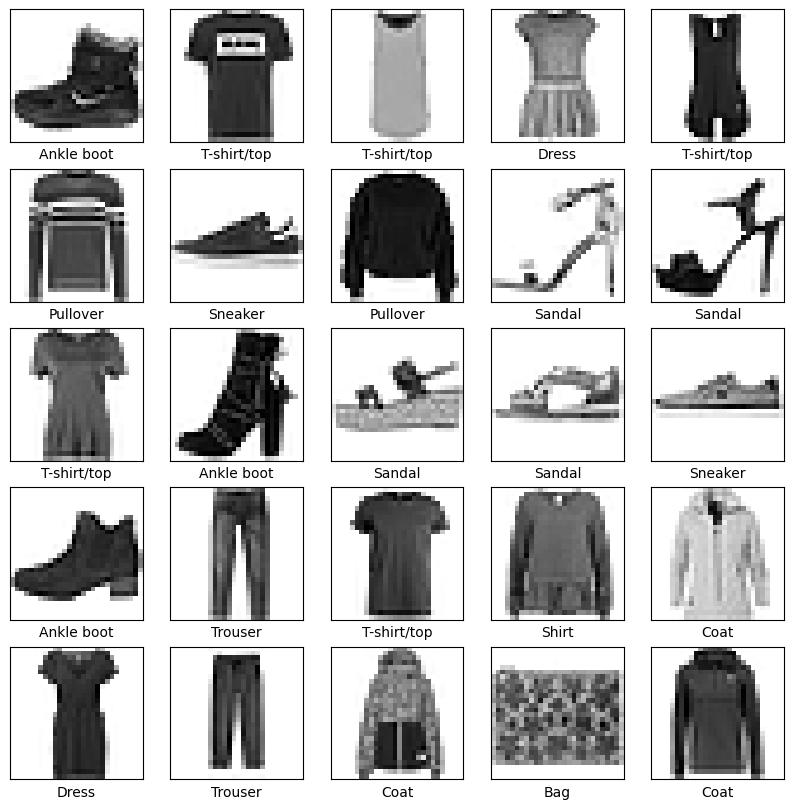

In [5]:
# 进行简单的可视化
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(labels[training_data[i][1]])
plt.show()

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

In [7]:
# TODO 数据加载器(1')
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# TODO 按照下图定义模型(2')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = torch.flatten(x, 1)  # 将输入张量展平成一维
        x = torch.relu(self.fc1(x))  # 第一个全连接层，使用ReLU激活函数
        x = self.fc2(x)  # 第二个全连接层，输出层
        return x

<?xml version="1.0" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="192pt" height="337pt" viewBox="0.00 0.00 192.15 337">
<g id="graph0" class="graph" transform="translate(13.086503072123655,316.16394050517243) scale(0.8420629536084173)" data-name="G">

<polygon fill="white" stroke="none" points="-4,4 -4,-333 188.15,-333 188.15,4 -4,4"/>
<!-- input -->
<g id="node1" class="node" pointer-events="visible" data-name="input">

<polygon fill="none" stroke="black" points="0,-292.5 0,-328.5 184.15,-328.5 184.15,-292.5 0,-292.5"/>
<text text-anchor="middle" x="22.78" y="-306.3" font-family="Times,serif" font-size="14.00">Input</text>
<polyline fill="none" stroke="black" points="45.55,-292.5 45.55,-328.5"/>
<text text-anchor="middle" x="114.85" y="-306.3" font-family="Times,serif" font-size="14.00">(Flatten到28*28=784)</text>
</g>
<!-- fc1 -->
<g id="node2" class="node" pointer-events="visible" data-name="fc1">

<polygon fill="none" stroke="black" points="34.9,-219.5 34.9,-255.5 149.25,-255.5 149.25,-219.5 34.9,-219.5"/>
<text text-anchor="middle" x="92.08" y="-233.4" font-family="Times,serif" font-size="14.00">Linear(784→128)</text>
</g>
<!-- input&#45;&gt;fc1 -->
<g id="edge1" class="edge" data-name="input-&gt;fc1">

<path fill="none" stroke="black" d="M92.08,-292.67C92.08,-284.89 92.08,-275.44 92.08,-266.62"/>
<polygon fill="black" stroke="black" points="95.58,-266.72 92.08,-256.72 88.58,-266.72 95.58,-266.72"/>
</g>
<!-- relu -->
<g id="node3" class="node" pointer-events="visible" data-name="relu">

<polygon fill="none" stroke="black" points="65.08,-146.5 65.08,-182.5 119.08,-182.5 119.08,-146.5 65.08,-146.5"/>
<text text-anchor="middle" x="91.68" y="-160.3" font-family="Times,serif" font-size="14.00">ReLU</text>
</g>
<!-- fc1&#45;&gt;relu -->
<g id="edge2" class="edge" data-name="fc1-&gt;relu">

<path fill="none" stroke="black" d="M92.08,-219.67C92.08,-211.89 92.08,-202.44 92.08,-193.62"/>
<polygon fill="black" stroke="black" points="95.58,-193.72 92.08,-183.72 88.58,-193.72 95.58,-193.72"/>
</g>
<!-- fc2 -->
<g id="node4" class="node" pointer-events="visible" data-name="fc2">

<polygon fill="none" stroke="black" points="38.4,-73.5 38.4,-109.5 145.75,-109.5 145.75,-73.5 38.4,-73.5"/>
<text text-anchor="middle" x="92.08" y="-87.4" font-family="Times,serif" font-size="14.00">Linear(129→10)</text>
</g>
<!-- relu&#45;&gt;fc2 -->
<g id="edge3" class="edge" data-name="relu-&gt;fc2">

<path fill="none" stroke="black" d="M92.08,-146.67C92.08,-138.89 92.08,-129.44 92.08,-120.62"/>
<polygon fill="black" stroke="black" points="95.58,-120.72 92.08,-110.72 88.58,-120.72 95.58,-120.72"/>
</g>
<!-- output -->
<g id="node5" class="node" pointer-events="visible" data-name="output">

<polygon fill="none" stroke="black" points="64.63,-0.5 64.63,-36.5 119.52,-36.5 119.52,-0.5 64.63,-0.5"/>
<text text-anchor="middle" x="92.08" y="-14.3" font-family="Times,serif" font-size="14.00">Output</text>
</g>
<!-- fc2&#45;&gt;output -->
<g id="edge4" class="edge" data-name="fc2-&gt;output">

<path fill="none" stroke="black" d="M92.08,-73.67C92.08,-65.89 92.08,-56.44 92.08,-47.62"/>
<polygon fill="black" stroke="black" points="95.58,-47.72 92.08,-37.72 88.58,-47.72 95.58,-47.72"/>
</g>
</g>
</svg>

In [9]:
# TODO 创建模型，并选择合适的优化器和损失函数(1')
model = Net()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [10]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()  # 清空梯度
        output = model(data)  # 前向传播
        loss = criterion(output, target)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
        train_loss += loss.item()  # 累加损失
        _, predicted = torch.max(output, 1)  # 获取预测类别
        total += target.size(0)  # 累加总样本数
        correct += (predicted == target).sum().item()  # 累加正确预测数
        
    return train_loss / len(train_dataloader), 100. * correct / total

def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch, (data, target) in enumerate(test_dataloader):
            output = model(data)  # 前向传播
            loss = criterion(output, target)  # 计算损失
            
            test_loss += loss.item()  # 累加损失
            _, predicted = torch.max(output, 1)  # 获取预测类别
            total += target.size(0)  # 累加总样本数
            correct += (predicted == target).sum().item()  # 累加正确预测数
            
    return test_loss / len(test_dataloader), 100. * correct / total

## 我改动了训练模型中保存pth的命名(加了时间戳),以避免后面加载其他模型导致的一个奇怪错误(不影响训练本身)

Epoch 1/10, Train Loss: 0.5458, Train Acc: 81.25%, Test Loss: 0.4665, Test Acc: 83.55%
Epoch 2/10, Train Loss: 0.4036, Train Acc: 85.74%, Test Loss: 0.4304, Test Acc: 84.72%
Epoch 3/10, Train Loss: 0.3639, Train Acc: 87.04%, Test Loss: 0.4000, Test Acc: 85.36%
Epoch 4/10, Train Loss: 0.3359, Train Acc: 87.84%, Test Loss: 0.3905, Test Acc: 86.14%
Epoch 5/10, Train Loss: 0.3178, Train Acc: 88.50%, Test Loss: 0.3657, Test Acc: 86.92%
Epoch 6/10, Train Loss: 0.3003, Train Acc: 89.09%, Test Loss: 0.3442, Test Acc: 87.65%
Epoch 7/10, Train Loss: 0.2875, Train Acc: 89.47%, Test Loss: 0.3554, Test Acc: 87.13%
Epoch 8/10, Train Loss: 0.2772, Train Acc: 89.90%, Test Loss: 0.3412, Test Acc: 87.84%
Epoch 9/10, Train Loss: 0.2659, Train Acc: 90.19%, Test Loss: 0.3359, Test Acc: 88.21%
Epoch 10/10, Train Loss: 0.2572, Train Acc: 90.59%, Test Loss: 0.3355, Test Acc: 88.02%


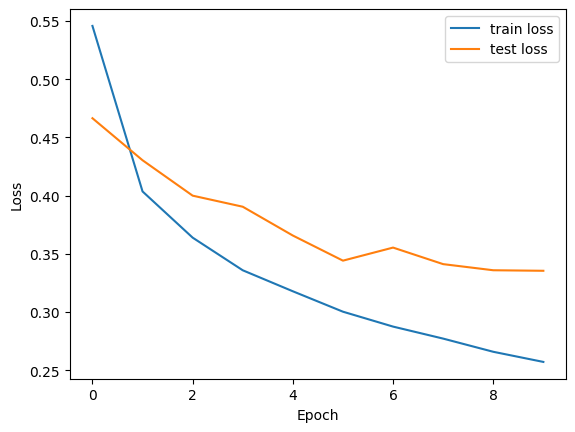

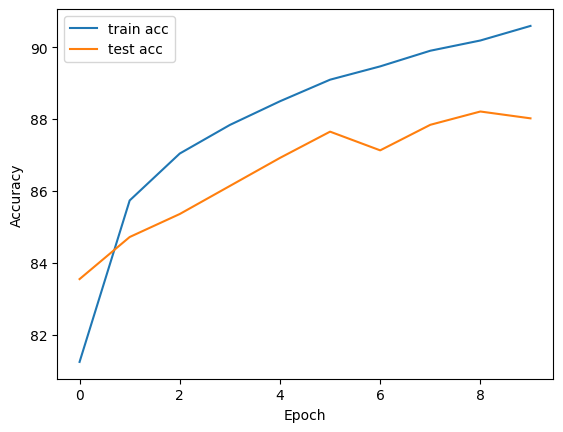

In [11]:
import time
# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = test(model, test_dataloader, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # 动态生成模型文件名
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model_filename = f'model_{timestamp}.pth'

    # 保存模型
    torch.save(model.state_dict(), model_filename)

    # 加载模型
    model = Net()  # 假设Net是你的模型类
    model.load_state_dict(torch.load(model_filename))

train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion)

## 模型调优与参数优化（5‘）
### 修改网络结构，**加入卷积层与池化层**。(2')

In [12]:
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 第一个卷积层和池化层
        x = self.pool(F.relu(self.conv2(x)))  # 第二个卷积层和池化层
        x = torch.flatten(x, 1)  # 将输入张量展平成一维
        x = F.relu(self.fc1(x))  # 第一个全连接层，使用ReLU激活函数
        x = self.fc2(x)  # 第二个全连接层，输出层
        return x

## 这里只是加了卷积和池化层,不训练了,更优的在下面


In [13]:
# model0 = Net0()
# optimizer0 = optim.Adam(model0.parameters(), lr=LEARNING_RATE)
# zhcriterion0 = nn.CrossEntropyLoss()
# train_and_test(model0, train_dataloader, test_dataloader, optimizer0, criterion0)

### 从包括但不限于以下方面对上述模型进行优化，要求至少尝试**两种**不同方面的优化方式，优化你的模型性能(2')
- 数据增强
- 早停策略
- 激活函数调整
- 正则化
- Dropout
- BatchNorm
- 网络结构调整
- 模型集成
- 超参数调优
- 其他技巧


## 我选择了BatchNorm和激活函数调整,测试集准确率在10个epoch时达到了92.90%

### 使得模型在FashionMNIST数据集上的准确率达到92%以上。(1')

In [14]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))  # 卷积层1 + 批量归一化 + Leaky ReLU + 池化
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))  # 卷积层2 + 批量归一化 + Leaky ReLU + 池化
        x = torch.flatten(x, 1)  # 将输入张量展平成一维
        x = self.dropout(F.leaky_relu(self.bn3(self.fc1(x)), negative_slope=0.01))  # 全连接层1 + 批量归一化 + Leaky ReLU + Dropout
        x = self.fc2(x)  # 全连接层2，输出层
        return x

model1 = Net1()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()

Epoch 1/10, Train Loss: 0.3956, Train Acc: 86.64%, Test Loss: 0.2753, Test Acc: 89.86%
Epoch 2/10, Train Loss: 0.2690, Train Acc: 90.54%, Test Loss: 0.2451, Test Acc: 90.89%
Epoch 3/10, Train Loss: 0.2344, Train Acc: 91.53%, Test Loss: 0.2332, Test Acc: 91.47%
Epoch 4/10, Train Loss: 0.2122, Train Acc: 92.46%, Test Loss: 0.2233, Test Acc: 92.40%
Epoch 5/10, Train Loss: 0.1917, Train Acc: 93.02%, Test Loss: 0.2075, Test Acc: 92.48%
Epoch 6/10, Train Loss: 0.1740, Train Acc: 93.67%, Test Loss: 0.2361, Test Acc: 91.56%
Epoch 7/10, Train Loss: 0.1638, Train Acc: 93.99%, Test Loss: 0.2111, Test Acc: 92.67%
Epoch 8/10, Train Loss: 0.1479, Train Acc: 94.53%, Test Loss: 0.2284, Test Acc: 92.38%
Epoch 9/10, Train Loss: 0.1413, Train Acc: 94.81%, Test Loss: 0.2236, Test Acc: 92.46%
Epoch 10/10, Train Loss: 0.1279, Train Acc: 95.26%, Test Loss: 0.2201, Test Acc: 92.90%


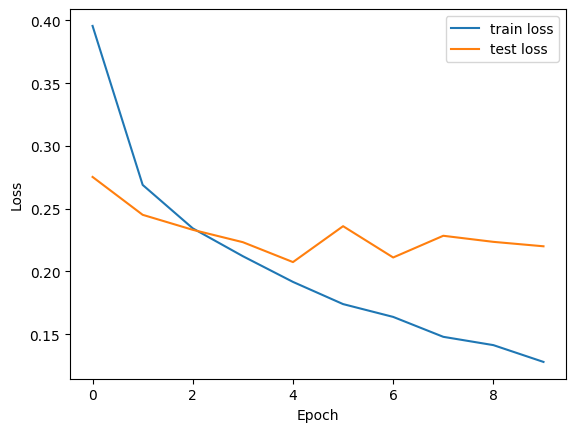

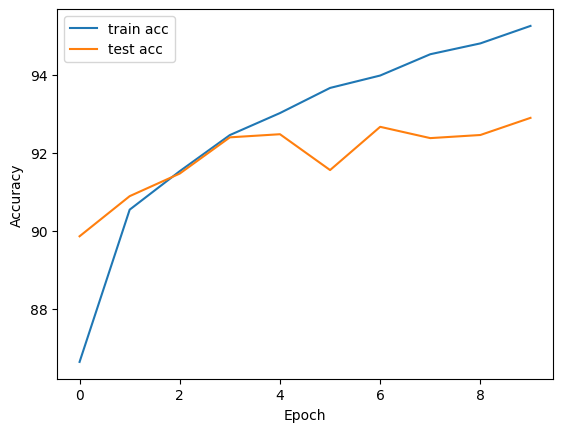

RuntimeError: Error(s) in loading state_dict for Net:
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "conv2.weight", "conv2.bias", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 3136]) from checkpoint, the shape in current model is torch.Size([128, 784]).

In [15]:
train_and_test(model1, train_dataloader, test_dataloader, optimizer1, criterion1)